In [1]:
#Importar las librerías necesarias para leer archivos y manipular datos
import pandas as pd
import numpy as np
import os
import sys
import re
import argparse
import matplotlib.pyplot as plt


In [2]:
#Levantar archivo .txt llamado sell-in.txt y ver el contenido
def read_file(file_path):
    try:
        with open(file_path, 'r') as file:
            content = file.read()
        return content
    except FileNotFoundError:
        print(f"Error: El archivo {file_path} no se encuentra.")
        sys.exit(1)

In [3]:
#Levantar el archivo CSV
sell_in = pd.read_csv(r'C:\Users\tomif\Desktop\Maestria\Laboratorio_3\sell-in.txt\sell-in.txt', sep='\t', encoding='utf-8')


In [4]:
sell_in.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2945818 entries, 0 to 2945817
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   periodo                int64  
 1   customer_id            int64  
 2   product_id             int64  
 3   plan_precios_cuidados  int64  
 4   cust_request_qty       int64  
 5   cust_request_tn        float64
 6   tn                     float64
dtypes: float64(2), int64(5)
memory usage: 157.3 MB


In [5]:
sell_in.head()

,periodo,customer_id,product_id,plan_precios_cuidados,cust_request_qty,cust_request_tn,tn
0,201701,10234,20524,0,2,0.05300,0.05300
1,201701,10032,20524,0,1,0.13628,0.13628
2,201701,10217,20524,0,1,0.03028,0.03028
3,201701,10125,20524,0,1,0.02271,0.02271
4,201701,10012,20524,0,11,1.54452,1.54452


In [6]:
tb_productos = pd.read_csv(r'C:\Users\tomif\Desktop\Maestria\Laboratorio_3\tb_productos.txt', sep='\t', encoding='utf-8')
tb_productos.head()



,cat1,cat2,cat3,brand,sku_size,product_id
0,HC,ROPA LAVADO,Liquido,LIMPIEX,900,20280
1,HC,ROPA LAVADO,Liquido,LIMPIEX,450,20180
2,HC,ROPA LAVADO,Liquido,LIMPIEX,120,20332
3,HC,ROPA LAVADO,Liquido,LIMPIEX,450,20222
4,HC,ROPA LAVADO,Liquido,LIMPIEX,900,20288


In [7]:
tb_stocks = pd.read_csv(r'C:\Users\tomif\Desktop\Maestria\Laboratorio_3\tb_stocks.txt', sep='\t', encoding='utf-8')
tb_stocks.head()

,periodo,product_id,stock_final
0,201810,20524,1.61267
1,201810,20311,2.93657
2,201810,20654,6.83269
3,201810,21005,1.01338
4,201810,20974,0.34595


In [8]:
tb_stocks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13691 entries, 0 to 13690
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   periodo      13691 non-null  int64  
 1   product_id   13691 non-null  int64  
 2   stock_final  13691 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 321.0 KB



### EDA SOBRE SELL_IN

In [9]:
#Transformar la columna periodo
sell_in['year'] = sell_in['periodo'].astype(str).str[:4].astype(int)
sell_in['month'] = sell_in['periodo'].astype(str).str[4:6].astype(int)
sell_in.head()

,periodo,customer_id,product_id,plan_precios_cuidados,cust_request_qty,cust_request_tn,tn,year,month
0,201701,10234,20524,0,2,0.05300,0.05300,2017,1
1,201701,10032,20524,0,1,0.13628,0.13628,2017,1
2,201701,10217,20524,0,1,0.03028,0.03028,2017,1
3,201701,10125,20524,0,1,0.02271,0.02271,2017,1
4,201701,10012,20524,0,11,1.54452,1.54452,2017,1


In [10]:
sell_in['year'].unique()

array([2017, 2018, 2019])

### VISUALIZAR ESTACIONALIDAD GENERAL DEL DATASET

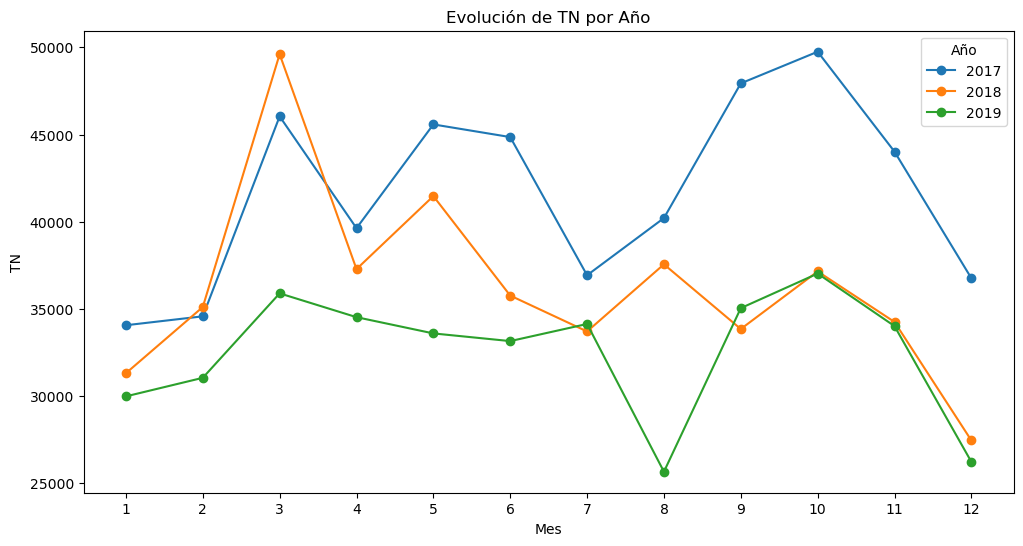

In [11]:
#sumarizar tn por year y hacer un grafico de lineas para ver como evoluciona tn en el tiempo
sell_in_grouped = sell_in.groupby(['year','month'])['tn'].sum().reset_index()
#graficar tn de forma tal que haya lineas por cada año y en eje X esten los meses
plt.figure(figsize=(12, 6))
for year in sell_in_grouped['year'].unique():
    plt.plot(sell_in_grouped[sell_in_grouped['year'] == year]['month'], 
             sell_in_grouped[sell_in_grouped['year'] == year]['tn'], 
             marker='o', label=year)
    
plt.title('Evolución de TN por Año')
plt.xlabel('Mes')
plt.ylabel('TN')
plt.xticks(sell_in_grouped['month'].unique())
plt.legend(title='Año')


In [12]:
tn_precios_cuidados = (
    sell_in[sell_in['plan_precios_cuidados'] == 1]
    .groupby(['year', 'month'])['tn']
    .sum()
    .reset_index()
    .rename(columns={'tn': 'tn_precios_cuidados'})
)

# Unir al dataframe agrupado principal
sell_in_grouped = sell_in_grouped.merge(
    tn_precios_cuidados, on=['year', 'month'], how='left'
)


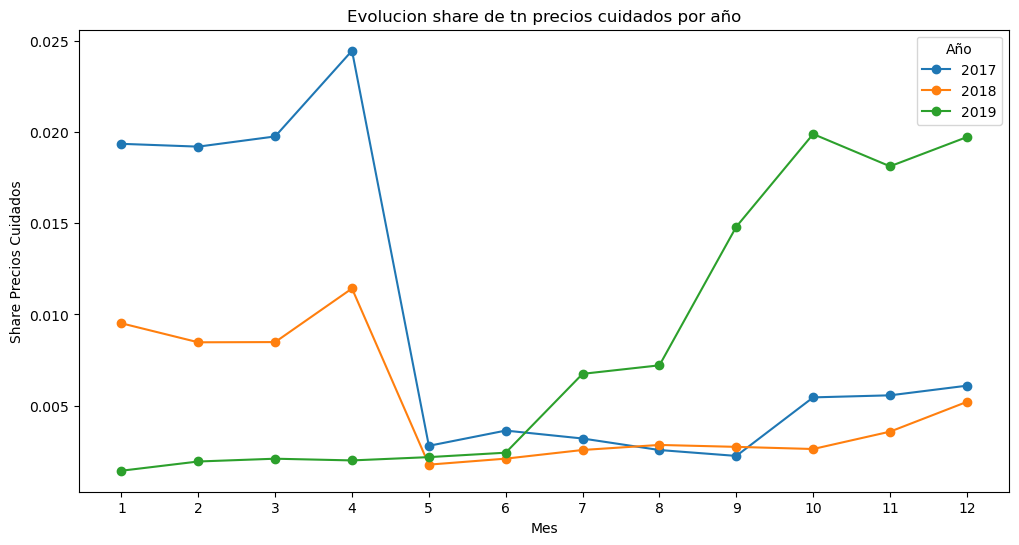

In [13]:
#share precios_cuidados como tn_precios_cuidados / tn
sell_in_grouped['share_precios_cuidados'] = (
    sell_in_grouped['tn_precios_cuidados'] / sell_in_grouped['tn']
)

#graficar share precios cuidados por year-month
plt.figure(figsize=(12, 6))
for year in sell_in_grouped['year'].unique():
    plt.plot(sell_in_grouped[sell_in_grouped['year'] == year]['month'], 
             sell_in_grouped[sell_in_grouped['year'] == year]['share_precios_cuidados'], 
             marker='o', label=year)
plt.title('Evolucion share de tn precios cuidados por año')
plt.xlabel('Mes')
plt.ylabel('Share Precios Cuidados')
plt.xticks(sell_in_grouped['month'].unique())
plt.legend(title='Año')
plt.show()

In [14]:
#Joinear sell_in_grouped con tb_productos a traves de product_id
df = (
    sell_in
    .merge(tb_productos, on='product_id', how='left')
    .merge(tb_stocks, on=['product_id', 'periodo'], how='left')
)


### DISTRIBUCION DE LA VENTA TN POR CATEGORIAS Y BRANDS

In [15]:
# Agrupar por año, mes y cat1 y sumar tn
cat1_tn = (
    df.groupby(['year', 'month', 'cat1'])['tn']
    .sum()
    .reset_index()
    .rename(columns={'tn': 'tn_cat1'})
)

# Calcular el total de tn por año y mes
total_tn = (
    df.groupby(['year', 'month'])['tn']
    .sum()
    .reset_index()
    .rename(columns={'tn': 'tn_total'})
)

# Unir ambos dataframes
cat1_tn = cat1_tn.merge(total_tn, on=['year', 'month'], how='left')

# Calcular el share
cat1_tn['share_tn_cat1'] = cat1_tn['tn_cat1'] / cat1_tn['tn_total']

cat1_tn.head()

,year,month,cat1,tn_cat1,tn_total,share_tn_cat1
0,2017,1,FOODS,6826.16102,35789.22945,0.190732
1,2017,1,HC,21686.66308,35789.22945,0.605955
2,2017,1,PC,7197.38367,35789.22945,0.201105
3,2017,1,REF,8.98416,35789.22945,0.000251
4,2017,2,FOODS,7730.78454,36668.76558,0.210828


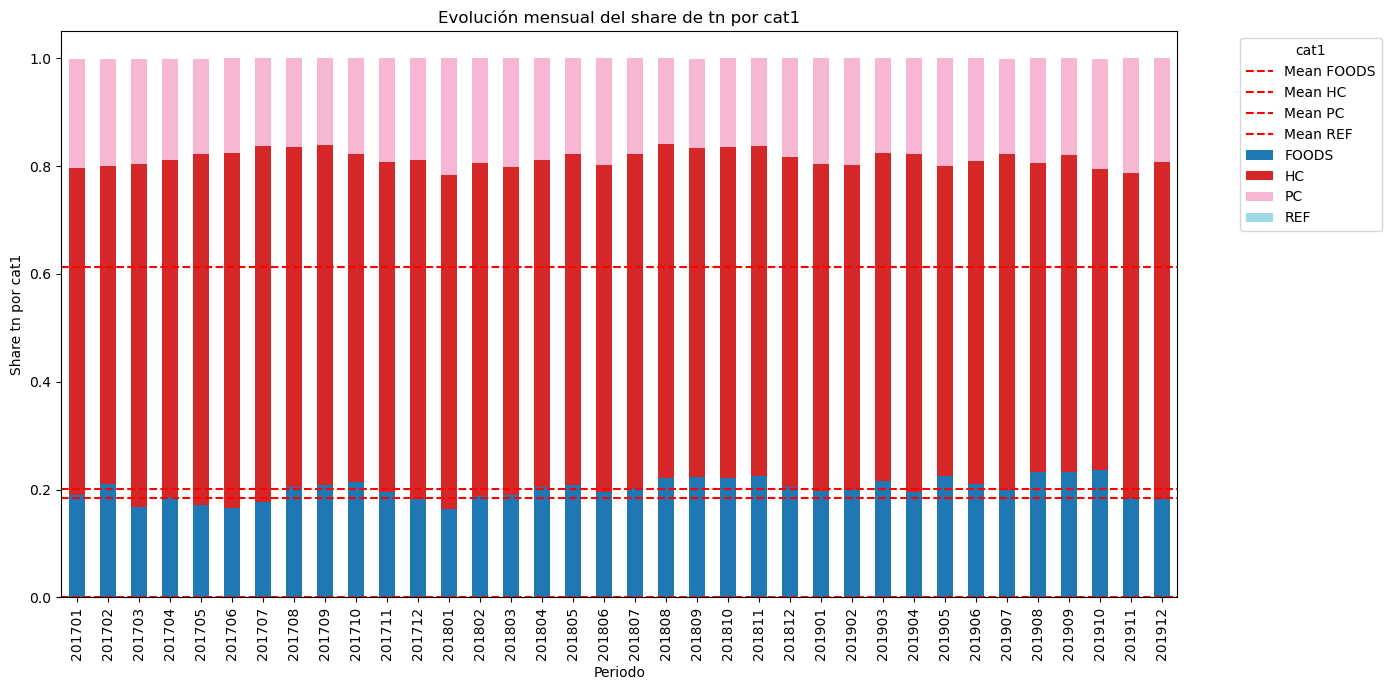

In [16]:
# Crear columna periodo en formato string (ej: '202201')
cat1_tn['periodo'] = cat1_tn['year'].astype(str) + cat1_tn['month'].astype(str).str.zfill(2)

# Pivotear el dataframe usando periodo como índice
cat1_pivot = cat1_tn.pivot_table(
    index='periodo',
    columns='cat1',
    values='share_tn_cat1',
    fill_value=0
)

# Graficar barras apiladas
cat1_pivot.plot(
    kind='bar',
    stacked=True,
    figsize=(14, 7),
    colormap='tab20'
)
#agregar una linea en el grafico que muestre el promedio del share por cat1 pero quiero que el valor de la linea este del lado derecho del eje Y
mean_values = cat1_pivot.mean()
for cat1 in cat1_pivot.columns:
    plt.axhline(y=mean_values[cat1], color='red', linestyle='--', label=f'Mean {cat1}')
# Agregar etiquetas y título
plt.title('Evolución mensual del share de tn por cat1')
plt.xlabel('Periodo')
plt.ylabel('Share tn por cat1')
plt.legend(title='cat1', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [17]:
df['brand'].unique()

array(['Importado', 'DEOS2', 'MAGGI', 'MUSCULO', 'MAYOS3', 'HARINAMA',
       'NIVEA', 'LANCOME', 'NATURA', 'DOWNY', 'DEOS3', 'COLBERT',
       'VIVERE', 'DEOS1', 'LIMPIEX', 'ARIEL', 'CAPILATIS', nan,
       'SHAMPOO3', 'SHAMPOO1', 'AYUDIN', 'MAGGI2', 'SHAMPOO2', 'ESPADOL',
       'ROPEX1', 'JABON1', 'MOSTAZA1', 'MAJESTA', 'GOMINA', 'TWININGS',
       'COLGATE', 'OFF', 'ROPEX2', 'SALSATI', 'SKIN1', 'VICHY', 'FRANCIA',
       'INDUSTRIAL'], dtype=object)

### Explorar valores NULOS

In [18]:
#Ver cuantos registros nulos hay por cada columna
def check_nulls(df):
    null_counts = df.isnull().sum()
    for column, count in null_counts.items():
        if count > 0:
            print(f"Columna '{column}' tiene {count} valores nulos.")
        else:
            print(f"Columna '{column}' no tiene valores nulos.")
#Ejecutar la funcion check_nulls
check_nulls(df)

Columna 'periodo' no tiene valores nulos.
Columna 'customer_id' no tiene valores nulos.
Columna 'product_id' no tiene valores nulos.
Columna 'plan_precios_cuidados' no tiene valores nulos.
Columna 'cust_request_qty' no tiene valores nulos.
Columna 'cust_request_tn' no tiene valores nulos.
Columna 'tn' no tiene valores nulos.
Columna 'year' no tiene valores nulos.
Columna 'month' no tiene valores nulos.
Columna 'cat1' tiene 7448 valores nulos.
Columna 'cat2' tiene 7448 valores nulos.
Columna 'cat3' tiene 7448 valores nulos.
Columna 'brand' tiene 7448 valores nulos.
Columna 'sku_size' tiene 7448 valores nulos.
Columna 'stock_final' tiene 1839319 valores nulos.


Los siguientes product_id tienen valores nulos en 'cat1': [21297 21249 21241 21225 21217 21272 21275 21066 21277 21274 21286 21285
 21253 21273 21240 21230 21268 21199 21165 21238 21178 21295 21223 21098
 21125 20848 20808 21281 21284 21278 21289 21279 21290 21283 21292 21298
 21296 21291 21288 21293 21299 20918 21228 21270 21169]
El 0.03% de las ventas de tn representan los productos que tienen nulls en 'tb_products'.


C:\Users\tomif\AppData\Local\Temp\ipykernel_9556\141536345.py:57: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(plot_df['periodo'], rotation=45)


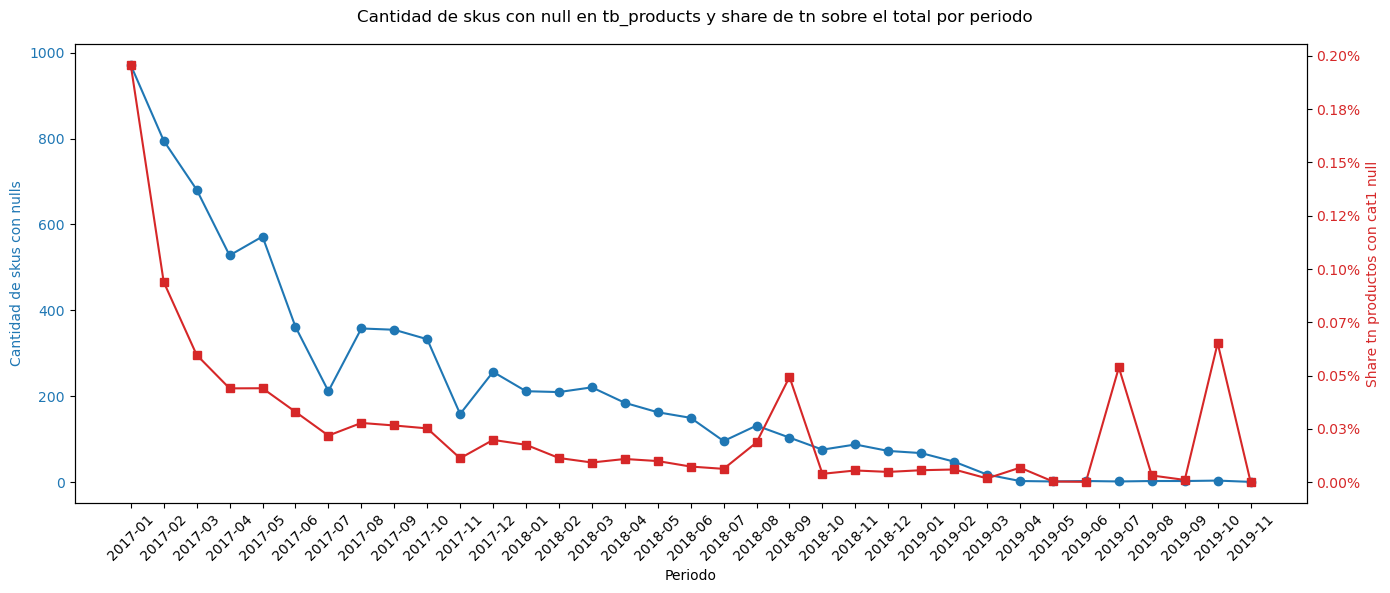

In [19]:
#Check product_id unicos que tienen nulls en la columna de cat1
def check_nulls_product_id(df):
    null_product_ids = df[df['cat1'].isnull()]['product_id'].unique()
    if len(null_product_ids) > 0:
        print(f"Los siguientes product_id tienen valores nulos en 'cat1': {null_product_ids}")
    else:
        print("No hay product_id con valores nulos en 'cat1'.")
check_nulls_product_id(df)

#Ver que % de las ventas de tn por mes representan los productos que tienen nulls en cat1
def check_nulls_percentage(df):
    total_tn = df['tn'].sum()
    null_tn = df[df['cat1'].isnull()]['tn'].sum()
    percentage = (null_tn / total_tn) * 100
    print(f"El {percentage:.2f}% de las ventas de tn representan los productos que tienen nulls en 'tb_products'.")
check_nulls_percentage(df)

#Graficar la cantidad de productos con cat1 null por año,mes
def plot_nulls_by_year_month(df):
    # Cantidad de productos con cat1 nulo por año y mes
    null_counts = (
        df[df['cat1'].isnull()]
        .groupby(['year', 'month'])['product_id']
        .count()
        .reset_index()
        .rename(columns={'product_id': 'null_count'})
    )
    # Share de tn de productos con cat1 nulo por año y mes
    tn_null = (
        df[df['cat1'].isnull()]
        .groupby(['year', 'month'])['tn']
        .sum()
        .reset_index()
        .rename(columns={'tn': 'tn_null_tb_products'})
    )
    tn_total = (
        df.groupby(['year', 'month'])['tn']
        .sum()
        .reset_index()
        .rename(columns={'tn': 'tn_total'})
    )
    # Merge para calcular el share
    share_df = tn_null.merge(tn_total, on=['year', 'month'], how='left')
    share_df['share_tn_nulls'] = share_df['tn_null_tb_products'] / share_df['tn_total']

    # Unir ambos resultados para graficar juntos
    plot_df = null_counts.merge(share_df, on=['year', 'month'], how='left')
    plot_df['periodo'] = plot_df['year'].astype(str) + '-' + plot_df['month'].astype(str).str.zfill(2)

    fig, ax1 = plt.subplots(figsize=(14, 6))

    # Eje izquierdo: cantidad de skus con nulls
    ax1.plot(plot_df['periodo'], plot_df['null_count'], marker='o', color='tab:blue', label='Cantidad de skus con null')
    ax1.set_xlabel('Periodo')
    ax1.set_ylabel('Cantidad de skus con nulls', color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.set_xticklabels(plot_df['periodo'], rotation=45)

    # Eje derecho: share de tn con cat1 null
    ax2 = ax1.twinx()
    ax2.plot(plot_df['periodo'], plot_df['share_tn_nulls'], marker='s', color='tab:red', label='share tn sku nulls')
    ax2.set_ylabel('Share tn productos con cat1 null', color='tab:red')
    ax2.tick_params(axis='y', labelcolor='tab:red')
    ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.2%}'.format(y)))

    # Leyendas y título
    fig.suptitle('Cantidad de skus con null en tb_products y share de tn sobre el total por periodo')
    fig.tight_layout()
    plt.show()

# Llama a la función con tu dataframe
plot_nulls_by_year_month(df)

In [20]:
# Filtrar los registros con null en cat1
null_cat1_df = df[df['cat1'].isnull()]

# Contar cuántos product_id únicos con null en cat1 hay por customer_id
nulls_by_customer = (
    null_cat1_df.groupby('customer_id')['product_id']
    .nunique()
    .reset_index()
    .rename(columns={'product_id': 'unique_product_id_null_cat1'})
    .sort_values(by='unique_product_id_null_cat1', ascending=False)
)

#contar cuántos customer_id únicos tienen nulls
nulls_by_customer_count = null_cat1_df['customer_id'].nunique()
print(f"Cantidad de customer_id únicos con null en tb_products: {nulls_by_customer_count}")

Cantidad de customer_id únicos con null en tb_products: 477


### VER TOP PRODUCTOS POR AÑO

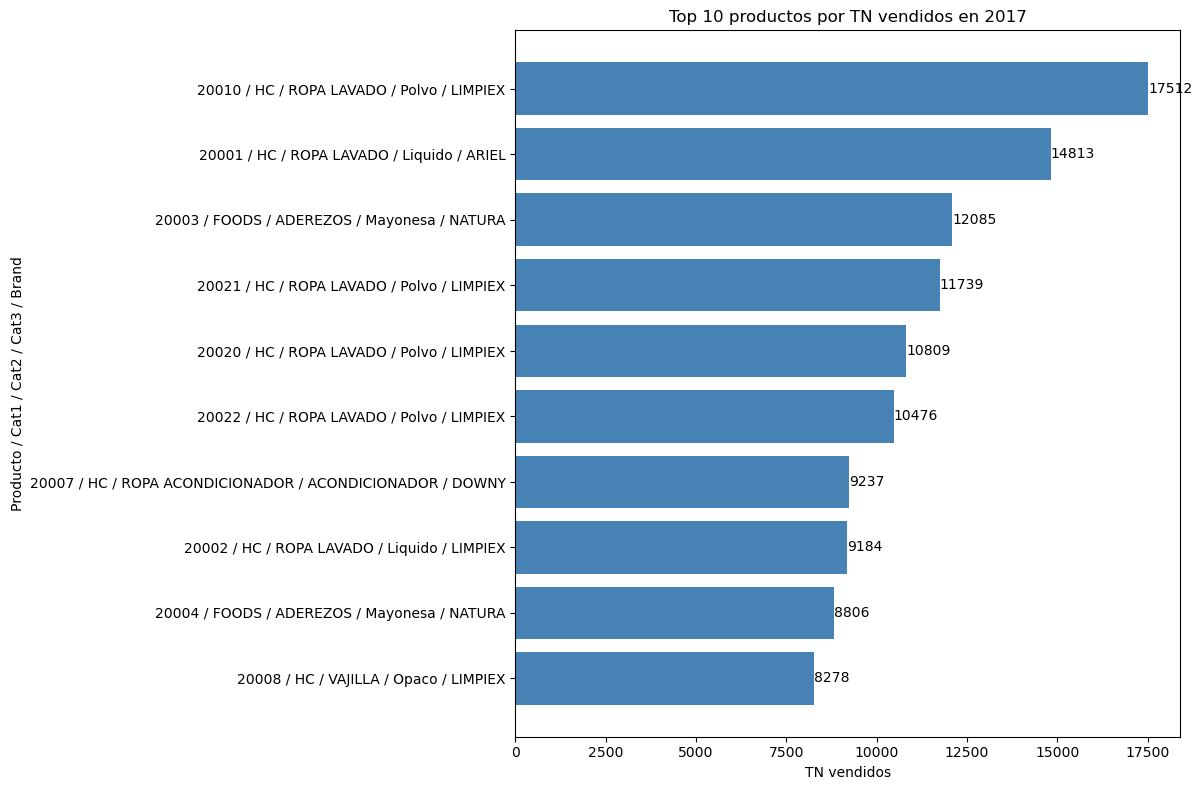

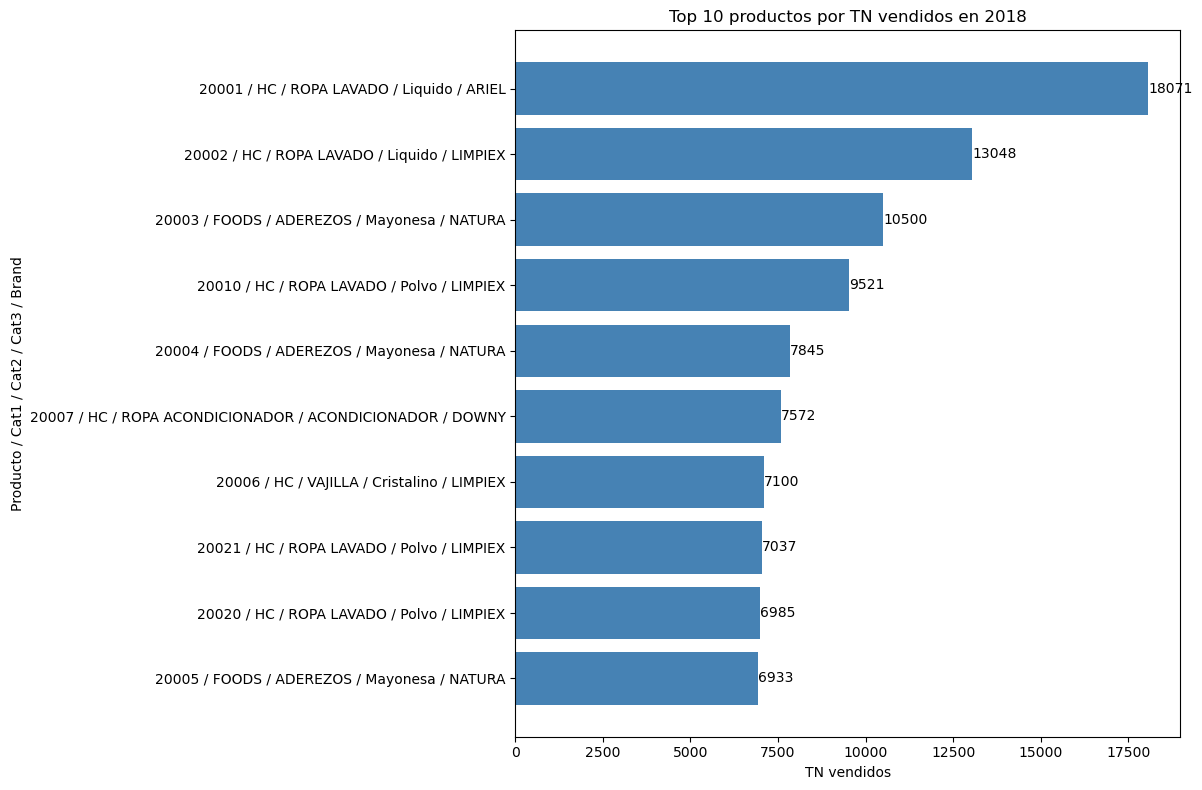

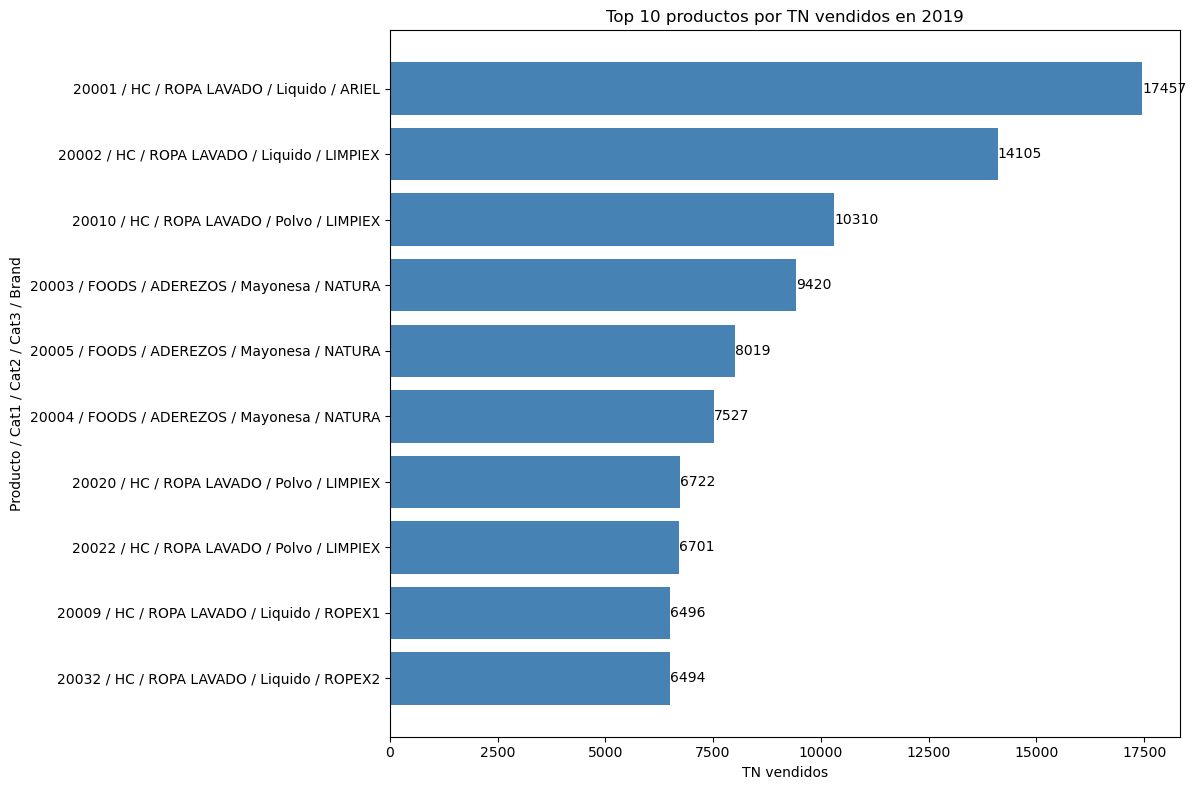

In [21]:
#Top 10 productos por año
for year in df['year'].unique():
    top_products = (
        df[df['year'] == year]
        .groupby(['product_id', 'cat1', 'cat2', 'cat3', 'brand'])['tn']
        .sum()
        .reset_index()
        .sort_values(by='tn', ascending=False)
        .head(10)
    )
    # Crear etiquetas combinadas
    top_products['label'] = (
        top_products['product_id'].astype(str) + ' / ' +
        top_products['cat1'].astype(str) + ' / ' +
        top_products['cat2'].astype(str) + ' / ' +
        top_products['cat3'].astype(str) + ' / ' +
        top_products['brand'].astype(str)
    )
    plt.figure(figsize=(12, 8))
    plt.barh(top_products['label'], top_products['tn'], color='steelblue')
    plt.title(f'Top 10 productos por TN vendidos en {year}')
    plt.xlabel('TN vendidos')
    plt.ylabel('Producto / Cat1 / Cat2 / Cat3 / Brand')
    plt.gca().invert_yaxis()  # Para que el más alto quede arriba
    for i, (v, label) in enumerate(zip(top_products['tn'], top_products['label'])):
        plt.text(v, i, f'{v:.0f}', va='center', ha='left')
    plt.tight_layout()
    plt.show()


### SERIES A NIVEL PRODUCT_CUSTOMER

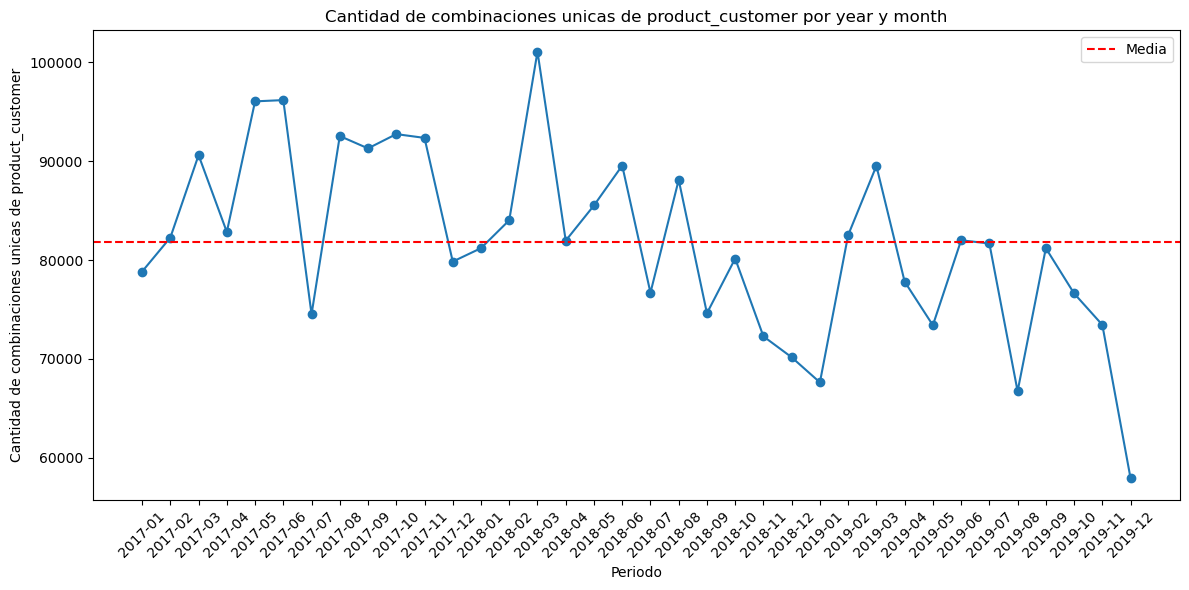

In [22]:
#crear una nueva columna que se llame "product_customer" que sea la concatenacion de product_id y customer_id
df['product_customer'] = df['product_id'].astype(str) + '_' + df['customer_id'].astype(str)
# Agrupar por year, mes y product_customer y contar cuantas combinaciones unicas de product_customer hay
product_customer_count = (
    df.groupby(['year', 'month'])['product_customer']
    .nunique()
    .reset_index()
    .rename(columns={'product_customer': 'unique_product_customer_count'})
)
#graficar la cantidad de combinaciones unicas de product_customer por year y month
#agregar una linea que sea la media de la cantidad de combinaciones unicas de product_customer por year y month
mean_product_customer = product_customer_count['unique_product_customer_count'].mean()
plt.figure(figsize=(12, 6))
plt.plot(product_customer_count['year'].astype(str) + '-' + product_customer_count['month'].astype(str).str.zfill(2), 
         product_customer_count['unique_product_customer_count'], marker='o')
plt.axhline(y=mean_product_customer, color='red', linestyle='--', label='Media')
plt.legend()
plt.title('Cantidad de combinaciones unicas de product_customer por year y month')
plt.xlabel('Periodo')
plt.ylabel('Cantidad de combinaciones unicas de product_customer')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### CUSTOMERS

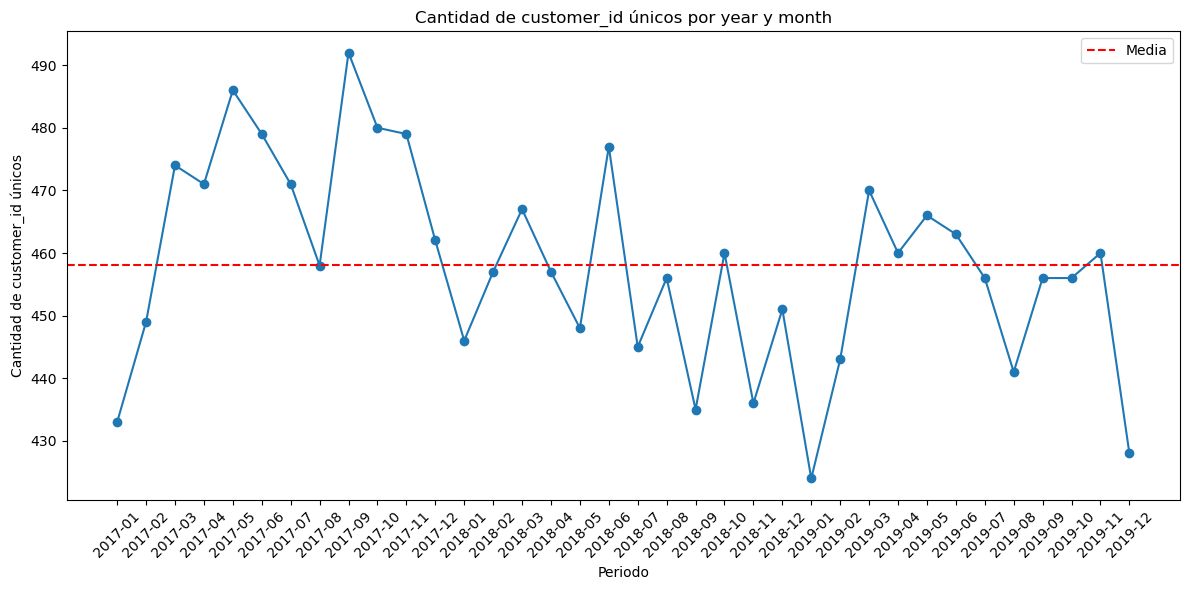

In [23]:
# Agrupar por year, month y contar cuántos customer_id únicos hay
customer_count = (
    df.groupby(['year', 'month'])['customer_id']
    .nunique()
    .reset_index()
    .rename(columns={'customer_id': 'unique_customer_count'})
)

# Calcular la media de customer_id únicos
mean_customer_count = customer_count['unique_customer_count'].mean()

# Graficar la cantidad de customer_id únicos por year y month
plt.figure(figsize=(12, 6))
plt.plot(
    customer_count['year'].astype(str) + '-' + customer_count['month'].astype(str).str.zfill(2),
    customer_count['unique_customer_count'],
    marker='o'
)
plt.axhline(y=mean_customer_count, color='red', linestyle='--', label='Media')
plt.legend()
plt.title('Cantidad de customer_id únicos por year y month')
plt.xlabel('Periodo')
plt.ylabel('Cantidad de customer_id únicos')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


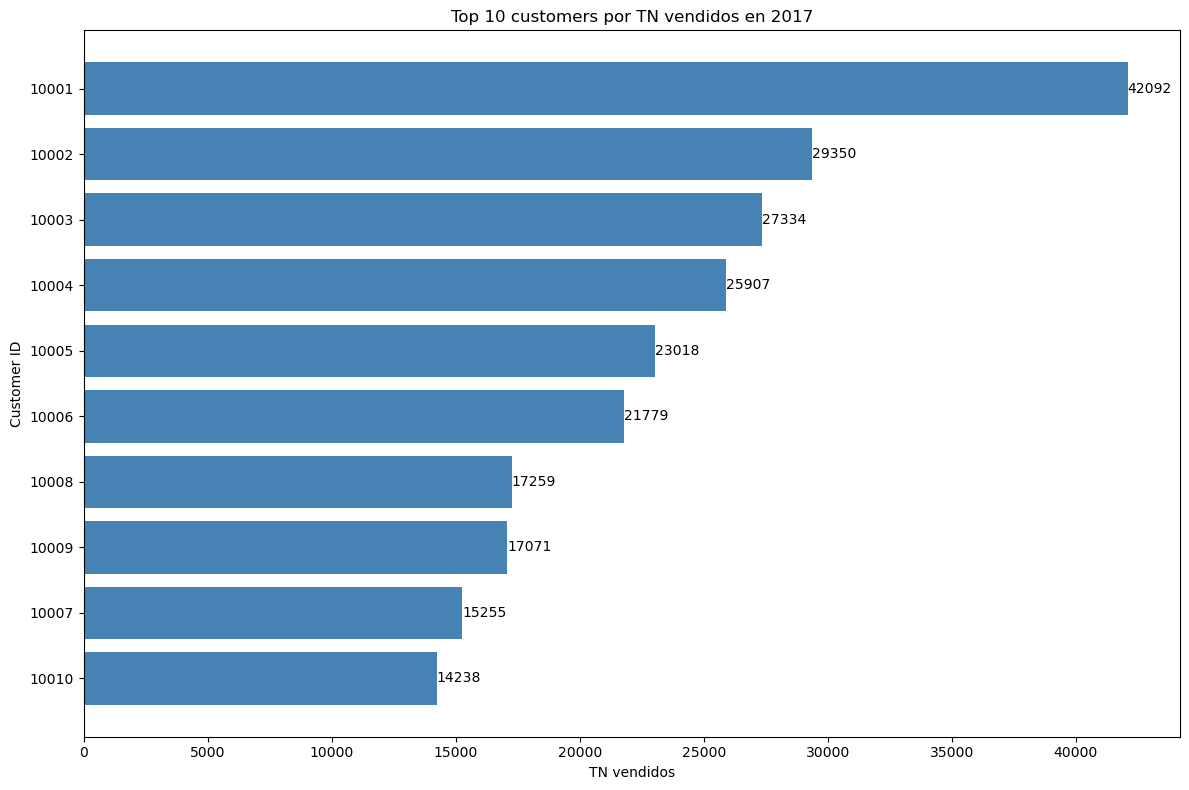

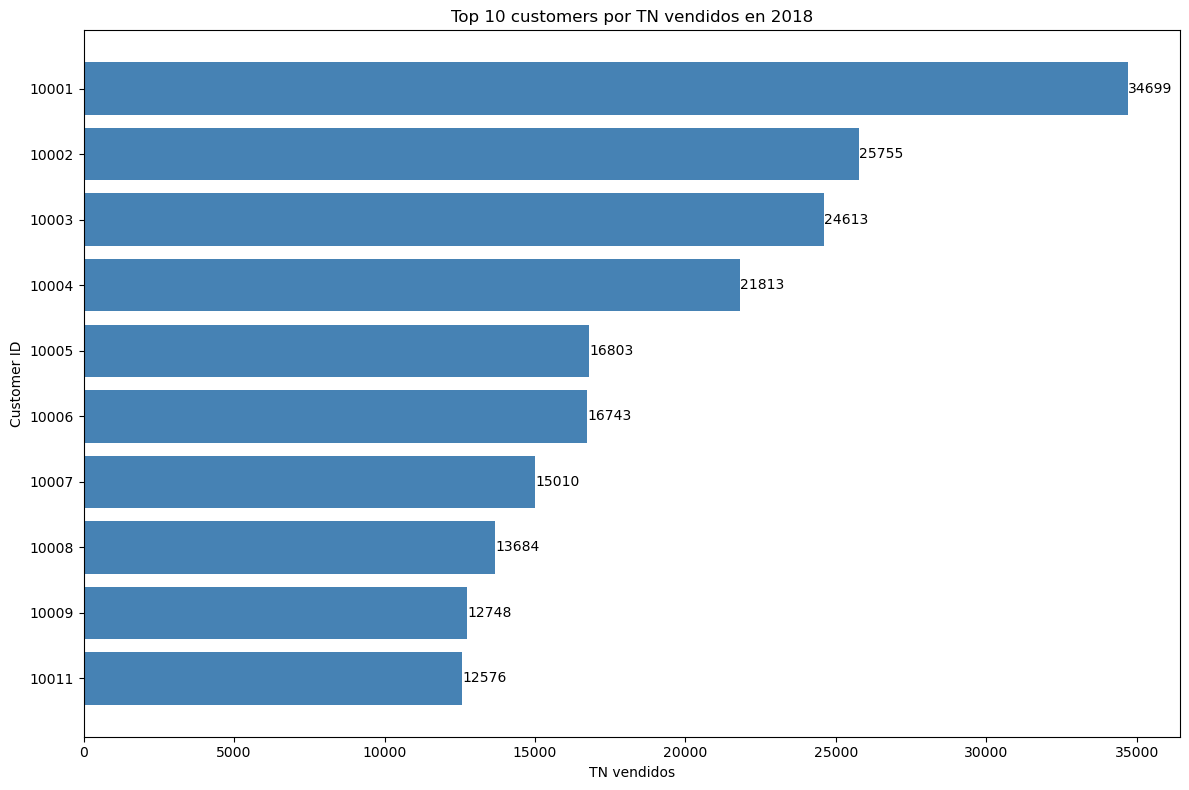

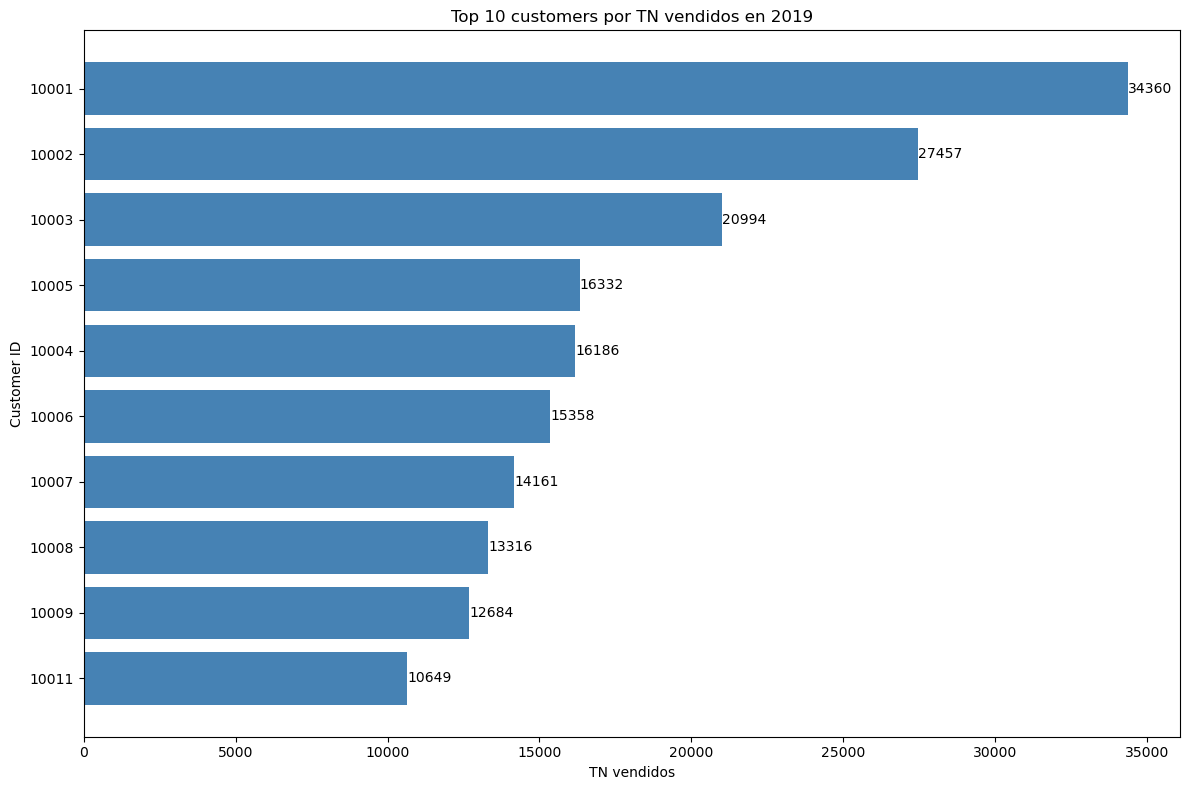

In [24]:
#Top 10 customers por año
for year in df['year'].unique():
    top_customers = (
        df[df['year'] == year]
        .groupby(['customer_id'])['tn']
        .sum()
        .reset_index()
        .sort_values(by='tn', ascending=False)
        .head(10)
    )
#grafico barras horizontales para ver por año los 10 customers que mas tn vendieron
    plt.figure(figsize=(12, 8))
    plt.barh(top_customers['customer_id'].astype(str), top_customers['tn'], color='steelblue')
    plt.title(f'Top 10 customers por TN vendidos en {year}')
    plt.xlabel('TN vendidos')
    plt.ylabel('Customer ID')
    plt.gca().invert_yaxis()  # Para que el más alto quede arriba
    for i, (v, label) in enumerate(zip(top_customers['tn'], top_customers['customer_id'])):
        plt.text(v, i, f'{v:.0f}', va='center', ha='left')
    plt.tight_layout()
    plt.show()    


### VISUALIZACION TOP 10 SERIES PRODUCTO_CUSTOMER X AÑO

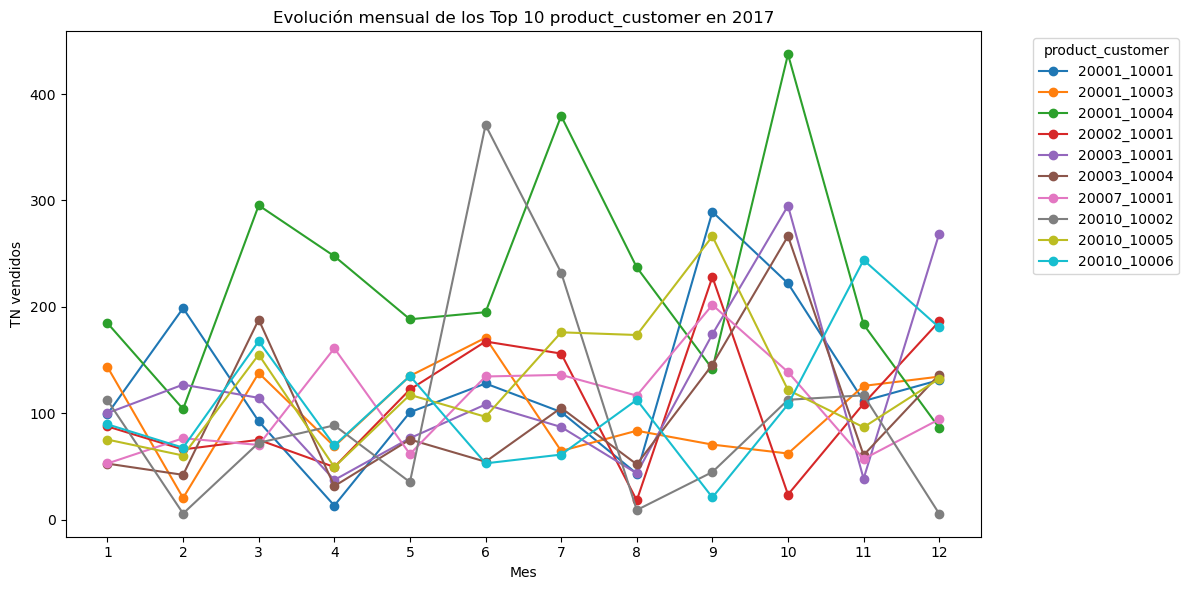

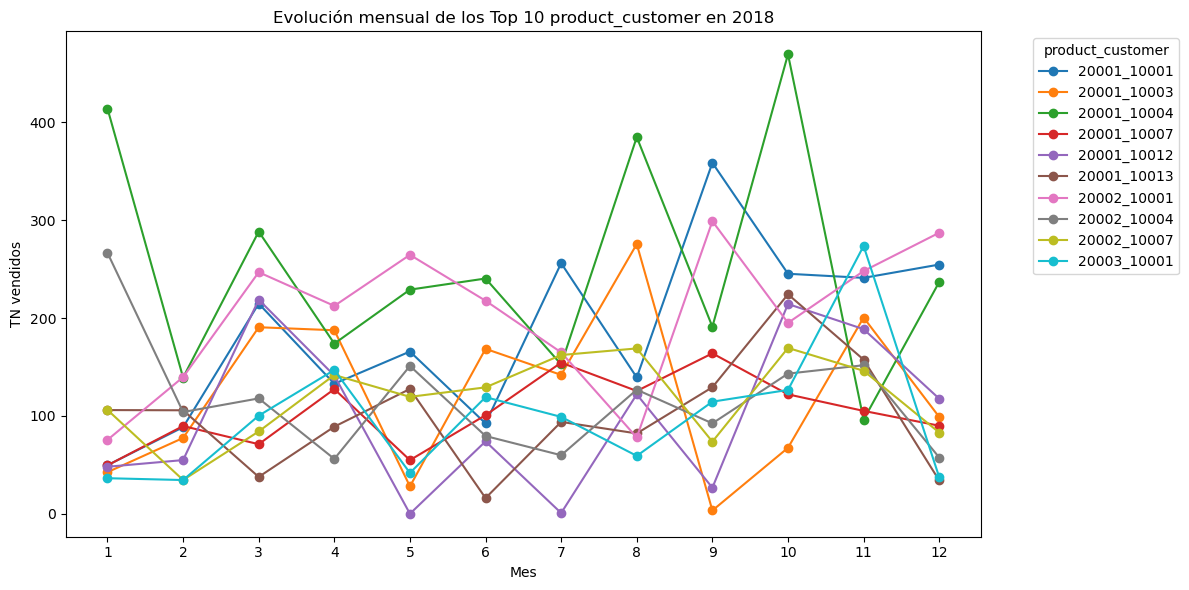

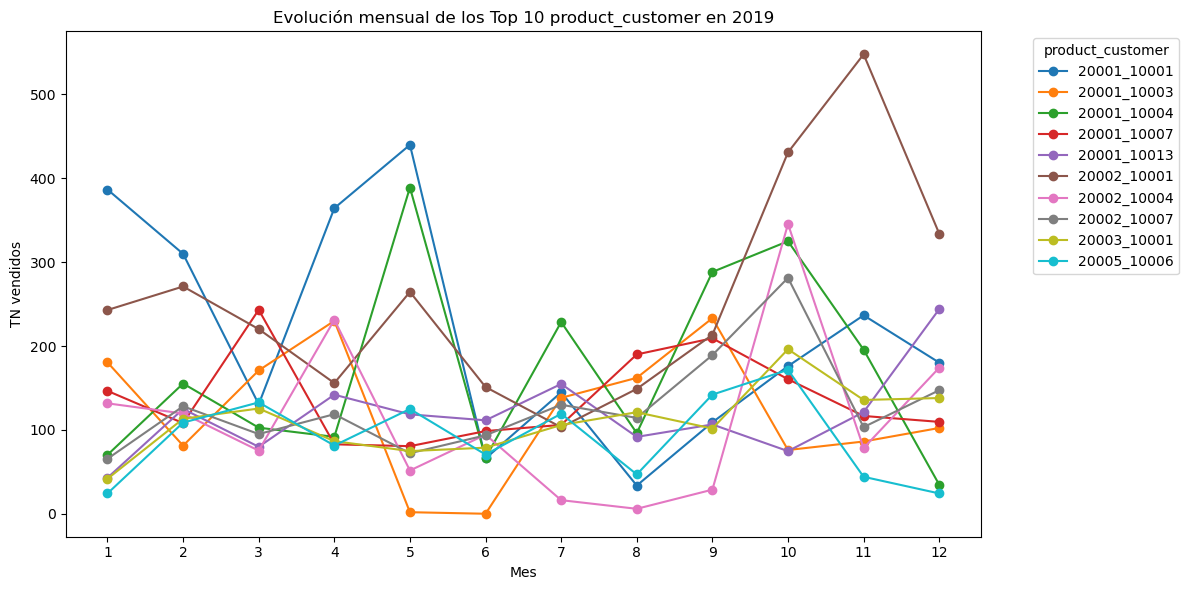

In [25]:
# Seleccionar los top 10 product_customer por año según la suma de tn
for year in df['year'].unique():
    # Top 10 product_customer del año según suma total de tn
    top_pc = (
        df[df['year'] == year]
        .groupby('product_customer')['tn']
        .sum()
        .reset_index()
        .sort_values(by='tn', ascending=False)
        .head(10)
        ['product_customer']
        .tolist()
    )
    # Filtrar solo esos product_customer para ese año
    df_top = df[(df['year'] == year) & (df['product_customer'].isin(top_pc))]
    # Agrupar por mes y product_customer
    pc_month = (
        df_top.groupby(['month', 'product_customer'])['tn']
        .sum()
        .reset_index()
    )
    # Pivotear para graficar
    pc_pivot = pc_month.pivot(index='month', columns='product_customer', values='tn').fillna(0)
    # Graficar
    plt.figure(figsize=(12, 6))
    for pc in pc_pivot.columns:
        plt.plot(pc_pivot.index, pc_pivot[pc], marker='o', label=pc)
    plt.title(f'Evolución mensual de los Top 10 product_customer en {year}')
    plt.xlabel('Mes')
    plt.ylabel('TN vendidos')
    plt.legend(title='product_customer', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(range(1, 13))
    plt.tight_layout()
    plt.show()

In [3]:

def transformar_periodo(df):
    df['fecha'] = pd.to_datetime(df['periodo'].astype(str), format='%Y%m')
    return df

def cargar_y_combinar_datos():
    # Cargar archivos
    sell_in = pd.read_csv('sell-in.txt', sep='\t')
    stocks = pd.read_csv('tb_stocks.txt', sep='\t')
    productos = pd.read_csv('tb_productos.txt', sep='\t')
    #drop duplicates in productos
    productos = productos.drop_duplicates(subset=['product_id'])

    df = sell_in.merge(stocks, on=['periodo', 'product_id'], how='left')
    df = df.merge(productos, on='product_id', how='left')

    return df



def completar_series_temporales_v2(df):
    """
    Completa las series temporales de productos y clientes cuando AMBOS estaban activos.
    Para productos, la fecha de fin es el máximo entre:
        - la última venta
        - la última fecha con stock_final > 0
    Si la última fecha cae en octubre, noviembre o diciembre de 2019,
    se asume que el cliente/producto siguió activo hasta el final del dataset.
    """
    import pandas as pd

    # Asegurar que 'fecha' es Period[M]
    df['fecha'] = pd.to_datetime(df['periodo'].astype(str), format='%Y%m')
    df['fecha'] = df['fecha'].astype('period[M]')

    columnas_a_rellenar = ['cust_request_qty', 'cust_request_tn', 'tn']

    # Última fecha global del dataset
    fecha_max_dataset = df['fecha'].max()

    # ----------------------------
    # CLIENTES
    # ----------------------------
    fechas_clientes = df.groupby('customer_id')['fecha'].agg(fecha_ini_c='min', fecha_fin_c='max').reset_index()

    # ----------------------------
    # PRODUCTOS
    # ----------------------------
    # Última fecha con venta
    fecha_venta = df.groupby('product_id')['fecha'].max().rename('fecha_venta')
    # Última fecha con stock > 0
    fecha_stock = df[df['stock_final'] > 0].groupby('product_id')['fecha'].max().rename('fecha_stock')

    # Merge y tomar el máximo entre ambas
    fechas_productos = pd.merge(fecha_venta, fecha_stock, how='outer', left_index=True, right_index=True)
    fechas_productos = fechas_productos.fillna(pd.Period('1900-01', freq='M'))  # para evitar NaNs
    fechas_productos['fecha_fin_p'] = fechas_productos[['fecha_venta', 'fecha_stock']].max(axis=1)

    # Agregar fecha de inicio (primera aparición en df)
    fechas_productos['fecha_ini_p'] = df.groupby('product_id')['fecha'].min()

    fechas_productos = fechas_productos.reset_index()[['product_id', 'fecha_ini_p', 'fecha_fin_p']]

    # ----------------------------
    # Extender vida si cae en oct/nov/dic 2019
    # ----------------------------
    meses_a_extender = [
        pd.Period('2019-08', freq='M'),
        pd.Period('2019-09', freq='M'),
        pd.Period('2019-10', freq='M'),
        pd.Period('2019-11', freq='M'),
        pd.Period('2019-12', freq='M')
    ]

    fechas_clientes['fecha_fin_c'] = fechas_clientes['fecha_fin_c'].apply(
        lambda x: fecha_max_dataset if x in meses_a_extender else x
    )
    fechas_productos['fecha_fin_p'] = fechas_productos['fecha_fin_p'].apply(
        lambda x: fecha_max_dataset if x in meses_a_extender else x
    )

    # ----------------------------
    # Generar combinaciones fecha-producto-cliente
    # ----------------------------
    fechas = pd.period_range(df['fecha'].min(), fecha_max_dataset, freq='M')
    fechas_df = pd.DataFrame({'fecha': fechas})

    clientes_fechas = fechas_clientes.merge(fechas_df, how='cross')
    clientes_fechas = clientes_fechas[
        (clientes_fechas['fecha'] >= clientes_fechas['fecha_ini_c']) &
        (clientes_fechas['fecha'] <= clientes_fechas['fecha_fin_c'])
    ][['customer_id', 'fecha']]

    productos_fechas = fechas_productos.merge(fechas_df, how='cross')
    productos_fechas = productos_fechas[
        (productos_fechas['fecha'] >= productos_fechas['fecha_ini_p']) &
        (productos_fechas['fecha'] <= productos_fechas['fecha_fin_p'])
    ][['product_id', 'fecha']]

    posibles_combinaciones = productos_fechas.merge(clientes_fechas, on='fecha', how='inner')

    df_full = posibles_combinaciones.merge(df, on=['product_id', 'customer_id', 'fecha'], how='left')
    df_full = df_full.sort_values(['product_id', 'customer_id', 'fecha'])

    # Ordenar
    df_full = df_full.sort_values(['product_id', 'customer_id', 'fecha'])

    # Forward fill para columnas no incluidas en columnas_a_rellenar ni claves
    claves = ['product_id', 'customer_id', 'fecha']
    columnas_ffill = [col for col in df_full.columns if col not in columnas_a_rellenar + claves]

    df_full[columnas_ffill] = (
        df_full.groupby(['product_id', 'customer_id'])[columnas_ffill].ffill()
    )

    # Completar demanda con 0
    df_full[columnas_a_rellenar] = df_full[columnas_a_rellenar].fillna(0)

    # Eliminar columna 'periodo' si está presente
    if 'periodo' in df_full.columns:
        df_full = df_full.drop(columns='periodo')

    return df_full.reset_index(drop=True)

def completar_series_temporales_v3(df,umbral_meses=8):
    """
    Completa las series temporales de productos y clientes cuando AMBOS estaban activos.
    Un cliente o producto se considera 'MUERTO' si entre la ultima fecha del dataset y su ultima fecha de compra pasaron mas de X meses definido por un umbral.
    Para el resto, se considera activo desde su primera compra hasta el fin del dataset.
    """
    import pandas as pd

    # Convertir columna 'periodo' (YYYYMM) a datetime y luego a Period[M]
    df['fecha'] = pd.to_datetime(df['periodo'].astype(str), format='%Y%m')
    df['fecha'] = df['fecha'].astype('period[M]')

    columnas_a_rellenar = ['cust_request_qty', 'cust_request_tn', 'tn']

    # Última fecha del dataset
    fecha_max_dataset = df['fecha'].max()

    # Definir umbral de inactividad
    umbral_fecha = fecha_max_dataset - umbral_meses

    # Fechas de inicio y fin por cliente y producto
    fechas_clientes = df.groupby('customer_id')['fecha'].agg(fecha_ini_c='min', fecha_fin_c='max').reset_index()
    fechas_productos = df.groupby('product_id')['fecha'].agg(fecha_ini_p='min', fecha_fin_p='max').reset_index()

    # Determinar cuáles clientes y productos están inactivos
    fechas_clientes['inactivo'] = fechas_clientes['fecha_fin_c'] <= umbral_fecha
    fechas_productos['inactivo'] = fechas_productos['fecha_fin_p'] <= umbral_fecha

    # Si está inactivo, se respeta la última fecha real; si no, se extiende hasta el final del dataset
    fechas_clientes['fecha_fin_c'] = fechas_clientes.apply(
        lambda x: x['fecha_fin_c'] if x['inactivo'] else fecha_max_dataset, axis=1
    )
    fechas_productos['fecha_fin_p'] = fechas_productos.apply(
        lambda x: x['fecha_fin_p'] if x['inactivo'] else fecha_max_dataset, axis=1
    )

    # Crear rango completo de fechas en formato Period[M]
    fechas = pd.period_range(df['fecha'].min(), fecha_max_dataset, freq='M')
    fechas_df = pd.DataFrame({'fecha': fechas})

    # Crear combinaciones válidas cliente-fecha
    clientes_fechas = fechas_clientes.merge(fechas_df, how='cross')
    clientes_fechas = clientes_fechas[
        (clientes_fechas['fecha'] >= clientes_fechas['fecha_ini_c']) &
        (clientes_fechas['fecha'] <= clientes_fechas['fecha_fin_c'])
    ][['customer_id', 'fecha']]

    # Crear combinaciones válidas producto-fecha
    productos_fechas = fechas_productos.merge(fechas_df, how='cross')
    productos_fechas = productos_fechas[
        (productos_fechas['fecha'] >= productos_fechas['fecha_ini_p']) &
        (productos_fechas['fecha'] <= productos_fechas['fecha_fin_p'])
    ][['product_id', 'fecha']]

    # Crear combinaciones cliente-producto-fecha donde ambos estaban activos
    combinaciones_validas = productos_fechas.merge(clientes_fechas, on='fecha', how='inner')

    # Merge con el dataset original
    df_completo = combinaciones_validas.merge(df, on=['product_id', 'customer_id', 'fecha'], how='left')

    # Completar valores faltantes con 0 en las columnas de cantidad
    df_completo[columnas_a_rellenar] = df_completo[columnas_a_rellenar].fillna(0)

    # Ordenar por producto, cliente y fecha
    df_completo = df_completo.sort_values(['product_id', 'customer_id', 'fecha'])

    return df_completo.reset_index(drop=True)


In [4]:
### CHECK DF 2
df = cargar_y_combinar_datos()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2945818 entries, 0 to 2945817
Data columns (total 13 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   periodo                int64  
 1   customer_id            int64  
 2   product_id             int64  
 3   plan_precios_cuidados  int64  
 4   cust_request_qty       int64  
 5   cust_request_tn        float64
 6   tn                     float64
 7   stock_final            float64
 8   cat1                   object 
 9   cat2                   object 
 10  cat3                   object 
 11  brand                  object 
 12  sku_size               float64
dtypes: float64(4), int64(5), object(4)
memory usage: 314.6+ MB


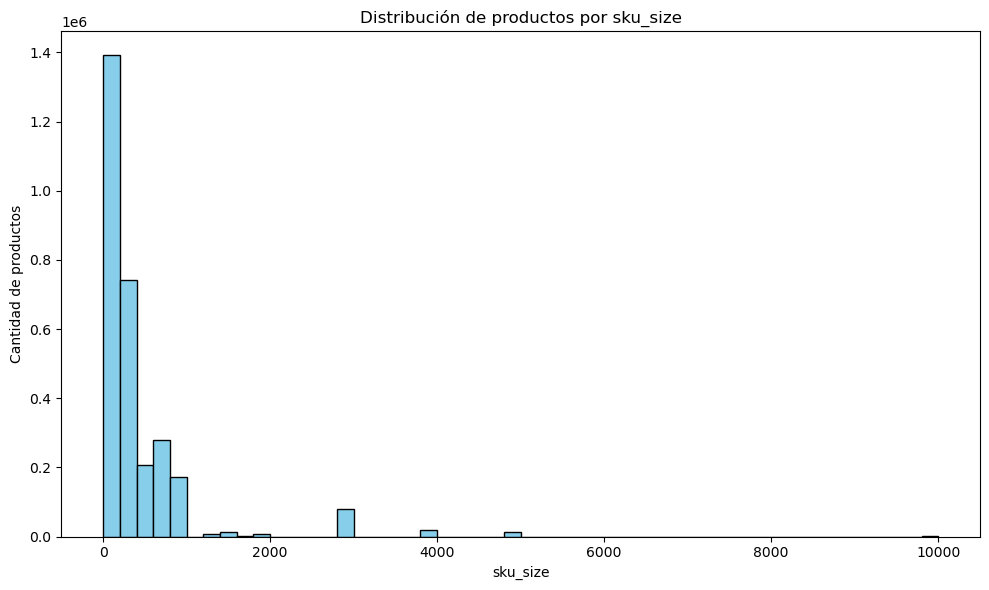

In [10]:
plt.figure(figsize=(10, 6))
plt.hist(df['sku_size'], bins=50, color='skyblue', edgecolor='black')  # Puedes ajustar el número de bins
plt.title('Distribución de productos por sku_size')
plt.xlabel('sku_size')
plt.ylabel('Cantidad de productos')
plt.tight_layout()
plt.show()

In [5]:
df_ampliado = completar_series_temporales_v3(df,umbral_meses=10)
df_ampliado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16181994 entries, 0 to 16181993
Data columns (total 14 columns):
 #   Column                 Dtype    
---  ------                 -----    
 0   product_id             int64    
 1   fecha                  period[M]
 2   customer_id            int64    
 3   periodo                float64  
 4   plan_precios_cuidados  float64  
 5   cust_request_qty       float64  
 6   cust_request_tn        float64  
 7   tn                     float64  
 8   stock_final            float64  
 9   cat1                   object   
 10  cat2                   object   
 11  cat3                   object   
 12  brand                  object   
 13  sku_size               float64  
dtypes: float64(7), int64(2), object(4), period[M](1)
memory usage: 1.7+ GB


In [12]:
df_ampliado.head()

,product_id,fecha,customer_id,plan_precios_cuidados,cust_request_qty,cust_request_tn,tn,stock_final,cat1,cat2,cat3,brand,sku_size
0,20001,2017-01,10001,0.0,11.0,99.43861,99.43861,NaN,HC,ROPA LAVADO,Liquido,ARIEL,3000.0
1,20001,2017-02,10001,0.0,23.0,198.84365,198.84365,NaN,HC,ROPA LAVADO,Liquido,ARIEL,3000.0
2,20001,2017-03,10001,0.0,33.0,92.46537,92.46537,NaN,HC,ROPA LAVADO,Liquido,ARIEL,3000.0
3,20001,2017-04,10001,0.0,8.0,13.29728,13.29728,NaN,HC,ROPA LAVADO,Liquido,ARIEL,3000.0
4,20001,2017-05,10001,0.0,15.0,101.20711,101.00563,NaN,HC,ROPA LAVADO,Liquido,ARIEL,3000.0


In [6]:
#filtrar df_2 por product_id = 20524
df_filt = df_ampliado[df_ampliado['product_id'] == 20008]
#mostrar de este producto el primer y ultimo registo
primer_registro = df_ampliado['fecha'].min()
ultimo_registro = df_ampliado['fecha'].max()
print(f"Primer registro de product_id 20524: {primer_registro}")
print(f"Último registro de product_id 20524: {ultimo_registro}")

Primer registro de product_id 20524: 2017-01
Último registro de product_id 20524: 2019-12


In [10]:
#filtrar df_2 por product_id = 20524
df_filt = df[df['customer_id'] == 10312]
#mostrar de este producto el primer y ultimo registo
primer_registro = df_filt['fecha'].min()
ultimo_registro = df_filt['fecha'].max()
print(f"Primer registro de customer_id 10312: {primer_registro}")
print(f"Último registro de customer_id 10312: {ultimo_registro}")

Primer registro de customer_id 10312: 2017-02
Último registro de customer_id 10312: 2019-11


In [9]:
#filtrar df_completo por product_id = 20524 customer_id = 10312
df_completo_filtrado = df_ampliado[(df_ampliado['product_id'] == 20524) & (df_ampliado['customer_id'] == 10312)]
df_completo_filtrado

,product_id,fecha,customer_id,periodo,plan_precios_cuidados,cust_request_qty,cust_request_tn,tn,stock_final,cat1,cat2,cat3,brand,sku_size
8185283,20524,2017-02,10312,NaN,NaN,0.0,0.00000,0.00000,NaN,NaN,NaN,NaN,NaN,NaN
8185284,20524,2017-03,10312,NaN,NaN,0.0,0.00000,0.00000,NaN,NaN,NaN,NaN,NaN,NaN
8185285,20524,2017-04,10312,NaN,NaN,0.0,0.00000,0.00000,NaN,NaN,NaN,NaN,NaN,NaN
8185286,20524,2017-05,10312,NaN,NaN,0.0,0.00000,0.00000,NaN,NaN,NaN,NaN,NaN,NaN
8185287,20524,2017-06,10312,NaN,NaN,0.0,0.00000,0.00000,NaN,NaN,NaN,NaN,NaN,NaN
8185288,20524,2017-07,10312,NaN,NaN,0.0,0.00000,0.00000,NaN,NaN,NaN,NaN,NaN,NaN
8185289,20524,2017-08,10312,NaN,NaN,0.0,0.00000,0.00000,NaN,NaN,NaN,NaN,NaN,NaN
8185290,20524,2017-09,10312,201709.0,0.0,1.0,0.01514,0.01514,NaN,HC,VAJILLA,Cristalino,Importado,500.0
8185291,20524,2017-10,10312,NaN,NaN,0.0,0.00000,0.00000,NaN,NaN,NaN,NaN,NaN,NaN
8185292,20524,2017-11,10312,NaN,NaN,0.0,0.00000,0.00000,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
#En df sumarizar tn agrupado por periodo y customer_id. Luego filtrar por customer_id = 10312
check_pdct = (
    df_ampliado.groupby(['fecha', 'cat2','cat3','brand','product_id'])['tn']
    .sum()
    .reset_index()
)
# Filtrar por customer_id = 10312
check_pdct = check_pdct[check_pdct['product_id'] == 20008]
check_pdct

,fecha,cat2,cat3,brand,product_id,tn
751,2017-01,VAJILLA,Opaco,LIMPIEX,20008,523.04609
1511,2017-02,VAJILLA,Opaco,LIMPIEX,20008,631.71430
2280,2017-03,VAJILLA,Opaco,LIMPIEX,20008,937.42393
3052,2017-04,VAJILLA,Opaco,LIMPIEX,20008,626.51768
3841,2017-05,VAJILLA,Opaco,LIMPIEX,20008,849.48973
4643,2017-06,VAJILLA,Opaco,LIMPIEX,20008,739.24267
5460,2017-07,VAJILLA,Opaco,LIMPIEX,20008,563.83449
6285,2017-08,VAJILLA,Opaco,LIMPIEX,20008,837.31906
7108,2017-09,VAJILLA,Opaco,LIMPIEX,20008,671.24800
7952,2017-10,VAJILLA,Opaco,LIMPIEX,20008,723.19292


In [10]:
#Ver top customer_id por tn de product_id = 20008
top_customers = (
    df_ampliado[df_ampliado['product_id'] == 20008]
    .groupby('customer_id')['tn']
    .sum()
    .reset_index()
    .sort_values(by='tn', ascending=False)
    .head(10)
)
top_customers

,customer_id,tn
1,10002,1837.76034
4,10005,1341.17833
8,10009,1120.56926
5,10006,1107.01842
0,10001,1072.48260
15,10016,705.21910
13,10014,670.98648
9,10010,624.00817
10,10011,549.79214
7,10008,493.69625


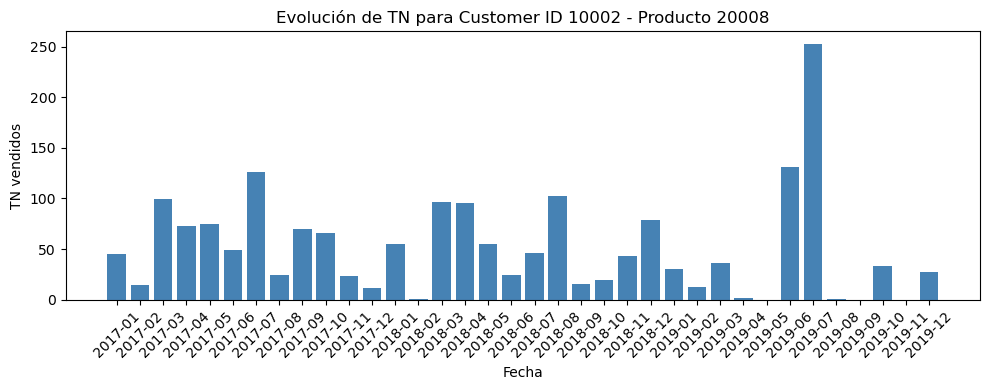

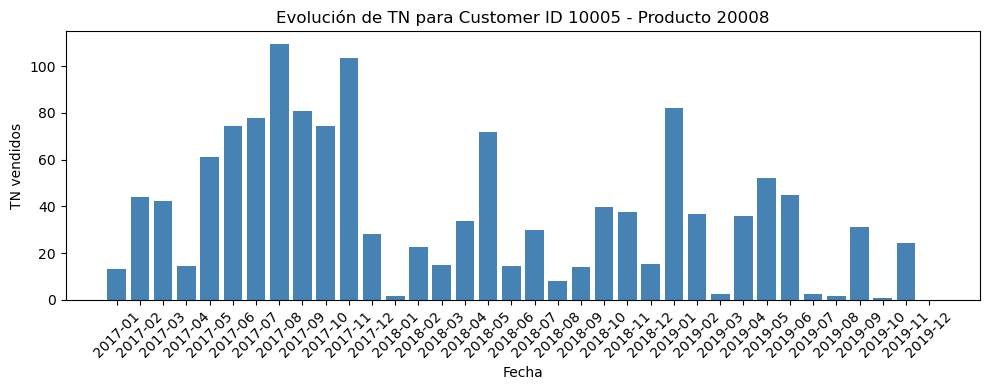

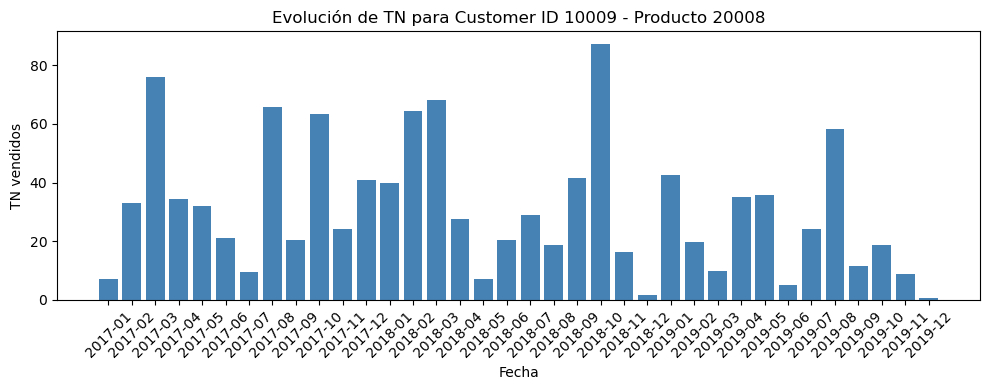

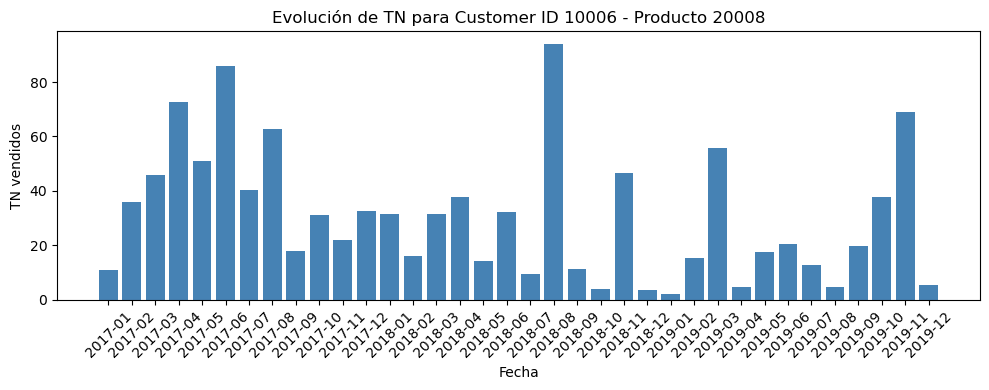

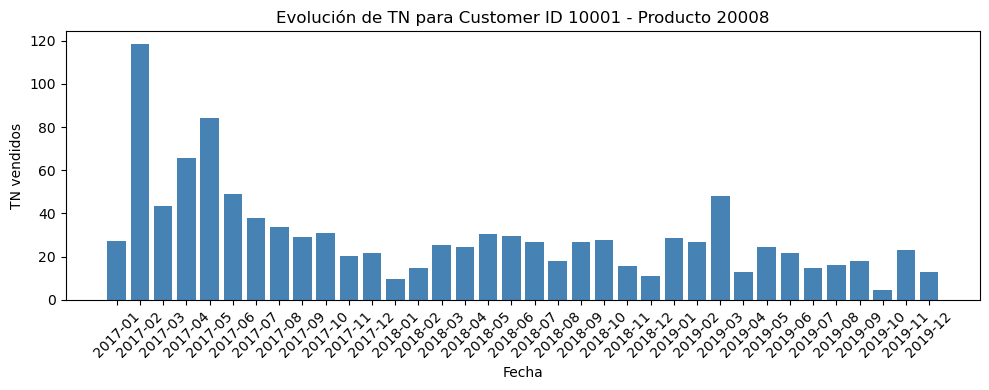

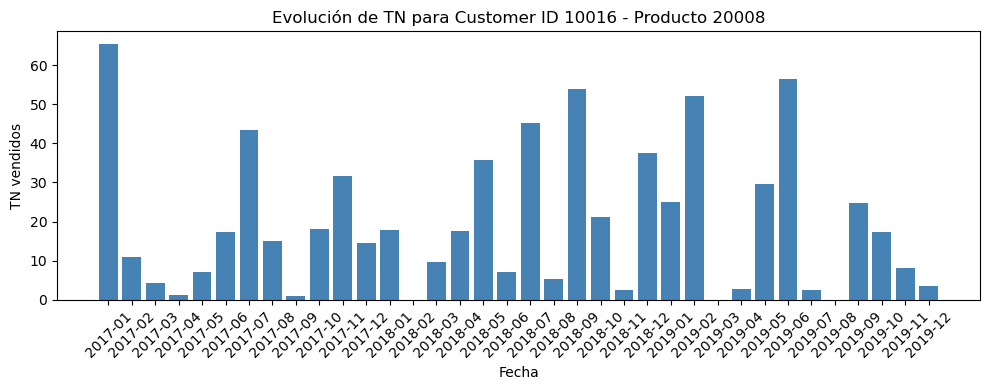

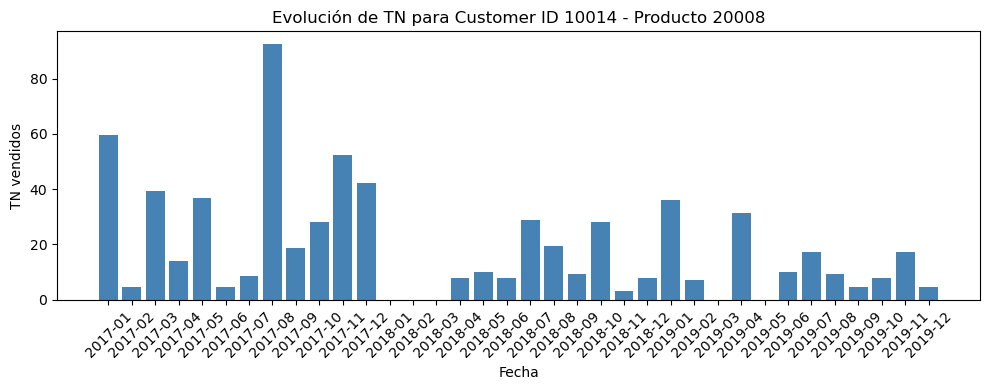

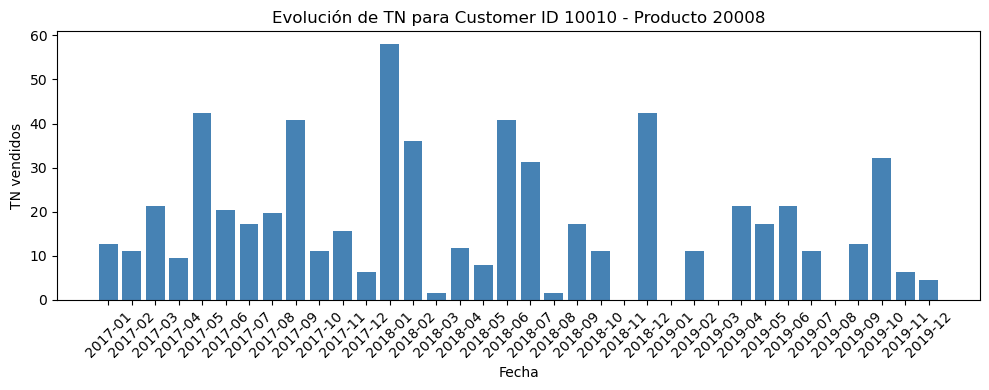

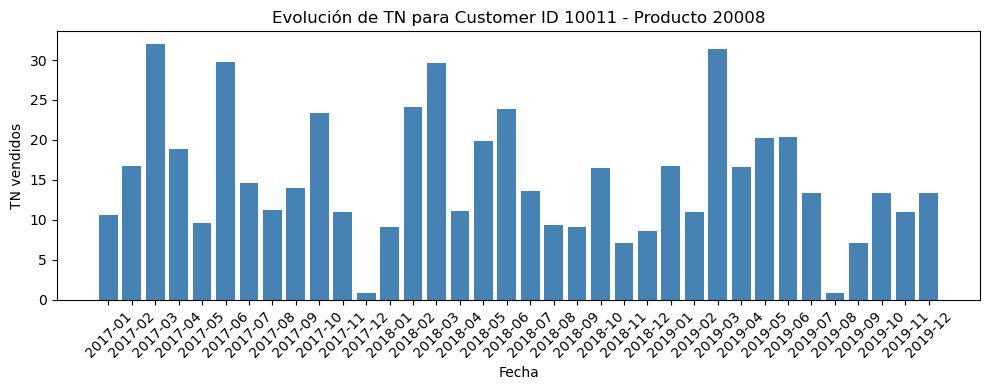

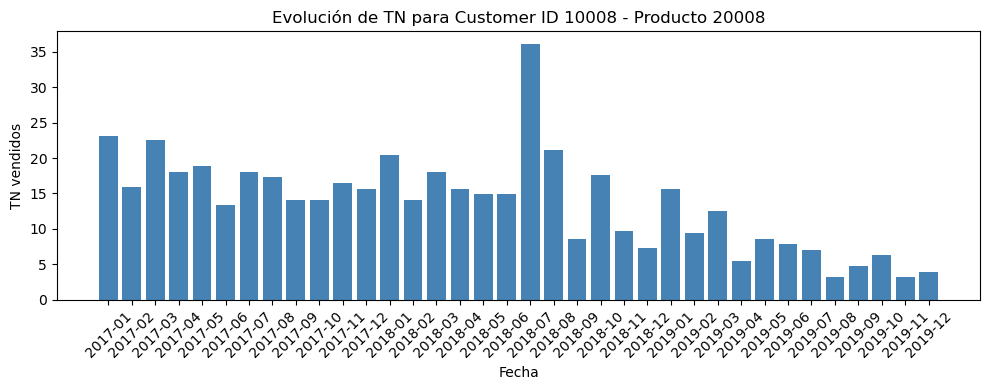

In [14]:
# Para cada customer del top, graficar su evolución de compra para el producto 20008
for customer in top_customers['customer_id']:
    customer_data = df_ampliado[
        (df_ampliado['customer_id'] == customer) & (df_ampliado['product_id'] == 20008)
    ]
    plt.figure(figsize=(10, 4))
    plt.bar(customer_data['fecha'].astype(str), customer_data['tn'], color='steelblue')
    plt.title(f'Evolución de TN para Customer ID {customer} - Producto 20008')
    plt.xlabel('Fecha')
    plt.ylabel('TN vendidos')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [27]:
import pandas as pd

# Asegurarte que la columna 'fecha' está en formato datetime
df['fecha'] = pd.to_datetime(df['periodo'].astype(str), format='%Y%m')

# Obtener fechas únicas de compra por cliente
compras = df[['customer_id', 'fecha']].drop_duplicates().sort_values(['customer_id', 'fecha'])

# Calcular la diferencia entre compras consecutivas por cliente
compras['diff_meses'] = compras.groupby('customer_id')['fecha'].diff().dt.days // 30  # Aprox. en meses

# Obtener el máximo período sin comprar por cliente
inactividad_maxima = compras.groupby('customer_id')['diff_meses'].max().reset_index()

# Ordenar para ver los más inactivos
inactividad_maxima = inactividad_maxima.sort_values('diff_meses', ascending=False)

inactividad_maxima.head(10)


,customer_id,diff_meses
516,10532,18.0
499,10512,13.0
421,10427,11.0
353,10354,11.0
514,10530,11.0
554,10574,11.0
561,10581,9.0
484,10495,8.0
520,10537,8.0
361,10362,8.0


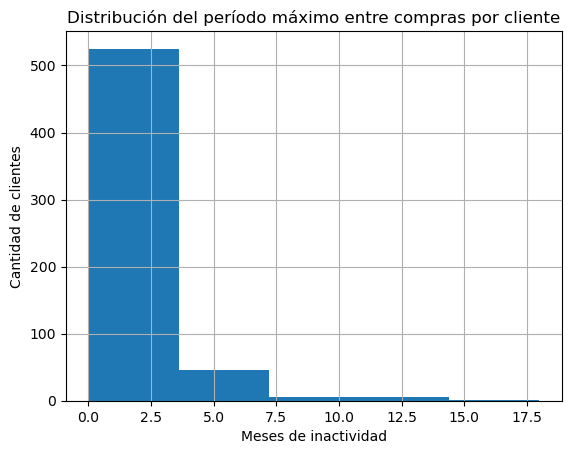

In [30]:
import matplotlib.pyplot as plt

inactividad_maxima['diff_meses'].hist(bins=5)
plt.title('Distribución del período máximo entre compras por cliente')
plt.xlabel('Meses de inactividad')
plt.ylabel('Cantidad de clientes')
plt.show()


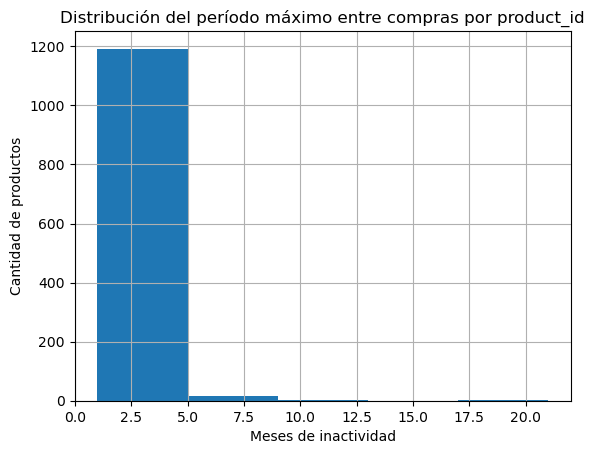

In [31]:
# Asegurarte que la columna 'fecha' está en formato datetime
df['fecha'] = pd.to_datetime(df['periodo'].astype(str), format='%Y%m')

# Obtener fechas únicas de compra por cliente
compras = df[['product_id', 'fecha']].drop_duplicates().sort_values(['product_id', 'fecha'])

# Calcular la diferencia entre compras consecutivas por cliente
compras['diff_meses'] = compras.groupby('product_id')['fecha'].diff().dt.days // 30  # Aprox. en meses

# Obtener el máximo período sin comprar por cliente
inactividad_maxima = compras.groupby('product_id')['diff_meses'].max().reset_index()

# Ordenar para ver los más inactivos
inactividad_maxima = inactividad_maxima.sort_values('diff_meses', ascending=False)

inactividad_maxima['diff_meses'].hist(bins=5)
plt.title('Distribución del período máximo entre compras por product_id')
plt.xlabel('Meses de inactividad')
plt.ylabel('Cantidad de productos')
plt.show()